# **importing necessary libraries**

In [1]:
import os 
import matplotlib.pylab as plt
import pandas as pd

import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics, linear_model
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential,Model
from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Activation, Reshape
from keras.layers import Concatenate, Dropout
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint
#from keras.utils import plot_model

plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
#reading the data
data_df=pd.read_csv("/content/test_scores.csv")
data_df.head()

,school,school_setting,school_type,classroom,teaching_method,n_student,student_id,gender,lunch,pretest,posttest
0,ANKYI,Urban,Non-public,6OL,Standard,20.0,2FHT3,Female,Does not qualify,62.0,72.0
1,ANKYI,Urban,Non-public,6OL,Standard,20.0,3JIVH,Female,Does not qualify,66.0,79.0
2,ANKYI,Urban,Non-public,6OL,Standard,20.0,3XOWE,Male,Does not qualify,64.0,76.0
3,ANKYI,Urban,Non-public,6OL,Standard,20.0,556O0,Female,Does not qualify,61.0,77.0
4,ANKYI,Urban,Non-public,6OL,Standard,20.0,74LOE,Male,Does not qualify,64.0,76.0


In [3]:
data_df.shape

(2133, 11)

In [4]:
target = ['posttest']

In [5]:
features = ['school','school_setting','school_type','classroom','teaching_method','n_student','student_id','gender','lunch','pretest']

# **Splitting into Train/Test Split**

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data_df.drop(['posttest'], axis = 1), data_df['posttest'], random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1599, 10), (534, 10), (1599,), (534,))

# **Categorical Features Embedding Preparation**

In [7]:
embed_cols=[i for i in X_train.select_dtypes(include=['object'])]

for i in embed_cols:
    print(i,data_df[i].nunique())

school 23
school_setting 3
school_type 2
classroom 97
teaching_method 2
student_id 2133
gender 2
lunch 2


In [8]:

#Categorical Features To List Format
embed_cols=[i for i in X_train.select_dtypes(include=['object'])]

#converting data to list format to match the network structure
def preproc(X_train,X_test):

    input_list_train = []
    # input_list_val = []
    input_list_test = []
    
    #the cols to be embedded: rescaling to range [0, # values)
    for c in embed_cols:
        raw_vals = np.unique(X_train[c])
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        input_list_train.append(X_train[c].map(val_map).values)
        # input_list_val.append(X_val[c].map(val_map).fillna(0).values)
        input_list_test.append(X_test[c].map(val_map).fillna(0).values)
     
    #the rest of the columns
    other_cols = [c for c in X_train.columns if (not c in embed_cols)]
    input_list_train.append(X_train[other_cols].values)
    # input_list_val.append(X_val[other_cols].values)
    input_list_test.append(X_test[other_cols].values)
    
    return input_list_train,input_list_test

In [9]:
input_list_train,input_list_test=preproc(X_train,X_test)


In [10]:
input_list_train

[array([ 0,  5, 21, ..., 12, 14,  9]),
 array([2, 0, 1, ..., 0, 2, 2]),
 array([0, 0, 1, ..., 1, 1, 0]),
 array([96,  4, 81, ..., 51, 70,  0]),
 array([1, 0, 0, ..., 1, 1, 1]),
 array([1419,  928,  476, ..., 1158,  449, 1581]),
 array([0, 1, 1, ..., 0, 1, 1]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([[21., 62.],
        [14., 65.],
        [23., 69.],
        ...,
        [19., 60.],
        [22., 49.],
        [22., 72.]])]

# ** Embedding size**

In [10]:
for categorical_var in X_train.select_dtypes(include=['object']):
    
    cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'
  
    no_of_unique_cat  = X_train[categorical_var].nunique()
    embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50 ))
  
    print('Categorica Variable:', categorical_var,
        'Unique Categories:', no_of_unique_cat,
        'Embedding Size:', embedding_size)

Categorica Variable: school Unique Categories: 23 Embedding Size: 12
Categorica Variable: school_setting Unique Categories: 3 Embedding Size: 2
Categorica Variable: school_type Unique Categories: 2 Embedding Size: 1
Categorica Variable: classroom Unique Categories: 97 Embedding Size: 49
Categorica Variable: teaching_method Unique Categories: 2 Embedding Size: 1
Categorica Variable: student_id Unique Categories: 1599 Embedding Size: 50
Categorica Variable: gender Unique Categories: 2 Embedding Size: 1
Categorica Variable: lunch Unique Categories: 2 Embedding Size: 1


In [11]:
#making proper name
for categorical_var in X_train.select_dtypes(include=['object']):
    
    input_name= 'Input_' + categorical_var.replace(" ", "")
    print(input_name)

Input_school
Input_school_setting
Input_school_type
Input_classroom
Input_teaching_method
Input_student_id
Input_gender
Input_lunch


In [17]:
input_models=[]
output_embeddings=[]
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

for categorical_var in X_train.select_dtypes(include=['object']):
    
    #Name of the categorical variable that will be used in the Keras Embedding layer
    cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'
  
    # Define the embedding_size
    no_of_unique_cat  = X_train[categorical_var].nunique()
    #embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50 ))
    embedding_size=50
  
    #One Embedding Layer for each categorical variable
    input_model = Input(shape=(1,))
    output_model = Embedding(no_of_unique_cat, embedding_size, name=cat_emb_name)(input_model)
    output_model = Reshape(target_shape=(embedding_size,))(output_model)    
  
    #Appending all the categorical inputs
    input_models.append(input_model)
  
    #Appending all the embeddings
    output_embeddings.append(output_model)
  
#Other non-categorical data columns (numerical). 
#I define single another network for the other columns and add them to our models list.
input_numeric = Input(shape=(len(X_train.select_dtypes(include=numerics).columns.tolist()),))
embedding_numeric = Dense(128)(input_numeric) 
input_models.append(input_numeric)
output_embeddings.append(embedding_numeric)

#At the end we concatenate altogther and add other Dense layers
output = Concatenate()(output_embeddings)
output = Dense(1000, kernel_initializer="uniform")(output)
output = Activation('relu')(output)
output= Dropout(0.4)(output)
output = Dense(512, kernel_initializer="uniform")(output)
output = Activation('relu')(output)
output= Dropout(0.3)(output)
output = Dense(1, activation='sigmoid')(output)

model = Model(inputs=input_models, outputs=output)
model.compile(loss='mse', optimizer='Adam',metrics=['mse'])

In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 1)]          0                                            
____________________________________________________________________________________________

In [19]:
X_train_list,input_list_test= preproc(X_train,X_test)

In [20]:
history  =  model.fit(X_train_list,y_train,validation_data=(input_list_test, y_test) , epochs =  500 , batch_size = 512, verbose= 2)

Epoch 1/500
4/4 - 4s - loss: 4558.9336 - mse: 4558.9336 - val_loss: 4609.0430 - val_mse: 4609.0430
Epoch 2/500
4/4 - 0s - loss: 4550.3447 - mse: 4550.3447 - val_loss: 4609.0430 - val_mse: 4609.0430
Epoch 3/500
4/4 - 0s - loss: 4550.3447 - mse: 4550.3447 - val_loss: 4609.0430 - val_mse: 4609.0430
Epoch 4/500
4/4 - 0s - loss: 4550.3447 - mse: 4550.3447 - val_loss: 4609.0430 - val_mse: 4609.0430
Epoch 5/500
4/4 - 0s - loss: 4550.3447 - mse: 4550.3447 - val_loss: 4609.0430 - val_mse: 4609.0430
Epoch 6/500
4/4 - 0s - loss: 4550.3447 - mse: 4550.3447 - val_loss: 4609.0430 - val_mse: 4609.0430
Epoch 7/500
4/4 - 0s - loss: 4550.3447 - mse: 4550.3447 - val_loss: 4609.0430 - val_mse: 4609.0430
Epoch 8/500
4/4 - 0s - loss: 4550.3447 - mse: 4550.3447 - val_loss: 4609.0430 - val_mse: 4609.0430
Epoch 9/500
4/4 - 0s - loss: 4550.3447 - mse: 4550.3447 - val_loss: 4609.0430 - val_mse: 4609.0430
Epoch 10/500
4/4 - 0s - loss: 4550.3447 - mse: 4550.3447 - val_loss: 4609.0430 - val_mse: 4609.0430
Epoch 11/

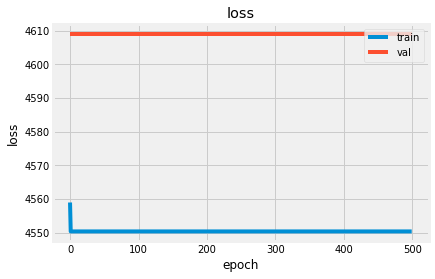

In [21]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()
